In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from corner import corner
from matplotlib import colormaps

In [2]:
Stats = namedtuple("Stats", ["num_stars", "num_samples", "times"])

In [3]:
cpu = Stats(
    [10, 17, 31, 56, 100],
    [2000, 4000, 4000, 4000, 2000],
    [195*2, 1256, 4865, 6210, 5149*2],
)
gpu = Stats(
    [10, 100, 200, 1000],
    [2000, 4000, 4000, 4000],
    [452*2, 3121, 3214, 3811],
)

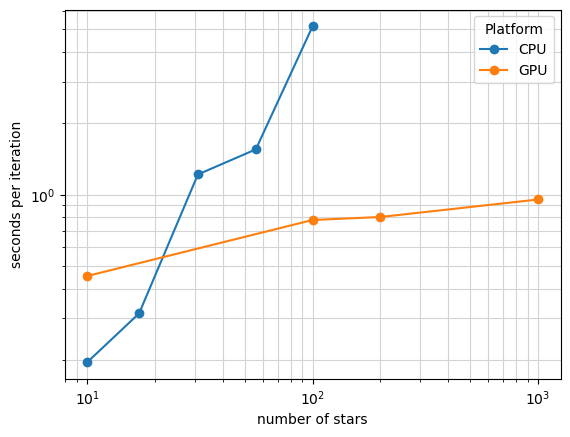

In [4]:
fig, ax = plt.subplots()
ax.plot(cpu.num_stars, np.divide(cpu.times, cpu.num_samples), "o-", label="CPU")
ax.plot(gpu.num_stars, np.divide(gpu.times, gpu.num_samples), "o-", label="GPU")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("number of stars")
ax.set_ylabel("seconds per iteration")
ax.legend(title="Platform")
ax.grid(which="both", color="lightgray")

In [5]:
import arviz as az

In [6]:
path = "/mnt/data-storage/alexlyttle/scalable-stellar-inference/8085102-01000-data.nc"
data = az.from_netcdf(path)
data

Inference data with groups:
	> posterior
	> sample_stats
	> constant_data

In [72]:
mask = ((data.posterior.log_Teff < np.log10(7700.)) & (data.posterior.log_age < np.log10(20.))).all(["star"])
mask

<xarray.DataArray (chain: 4, draw: 2000)>
array([[False, False,  True, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

In [66]:
mask = (data.posterior.log_Teff < np.log10(7600.)).all("star")
mask

<xarray.DataArray 'log_Teff' (chain: 4, draw: 2000)>
array([[ True,  True,  True, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       [False, False, False, ...,  True, False,  True]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

In [62]:
mask = (data.posterior.log_age < np.log10(20.)).all("star")
mask

<xarray.DataArray 'log_age' (chain: 4, draw: 2000)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True],
       [False, False,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

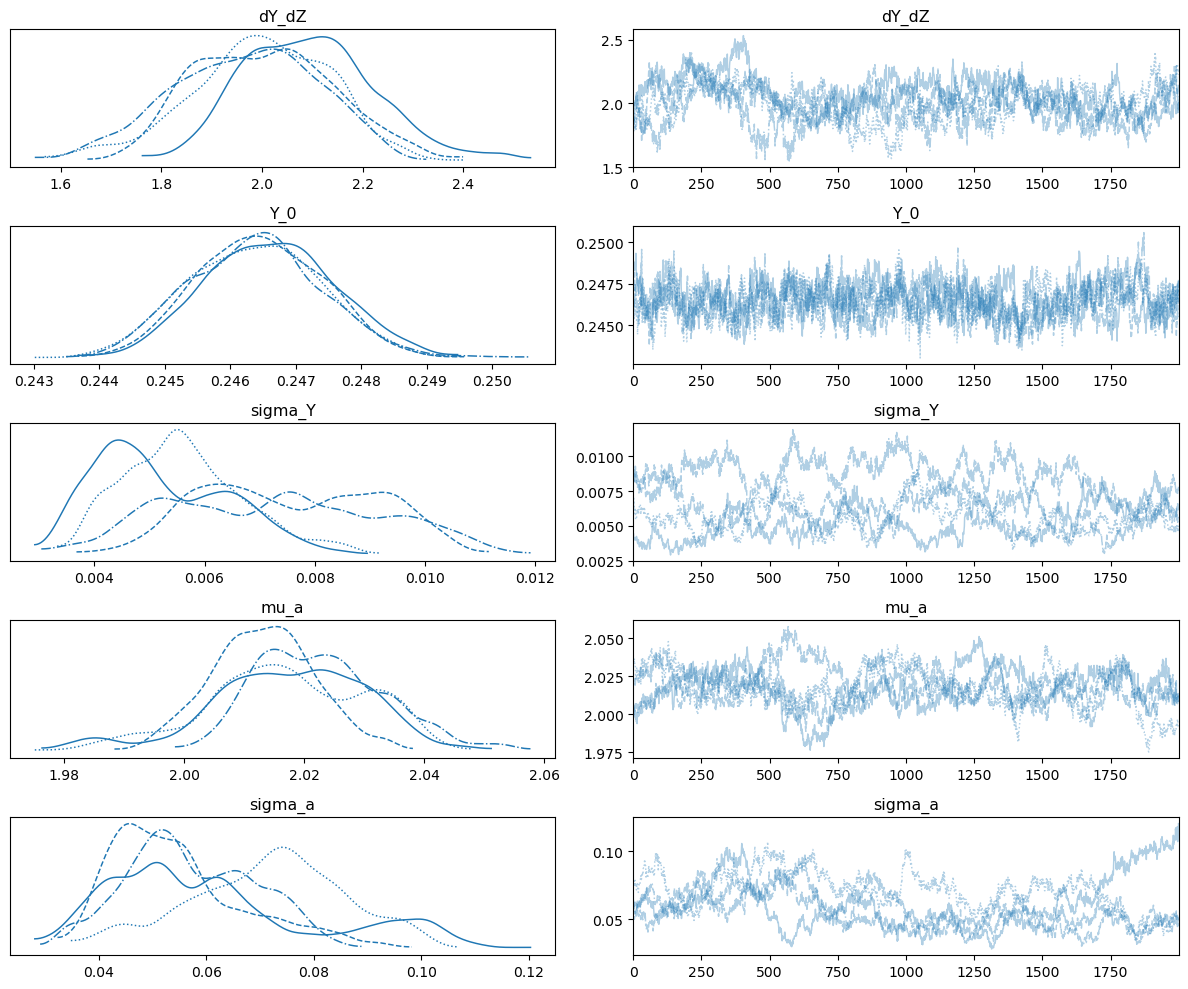

In [21]:
var_names = ["dY_dZ", "Y_0", "sigma_Y", "mu_a", "sigma_a"]
axes = az.plot_trace(data, var_names=var_names)
plt.tight_layout()

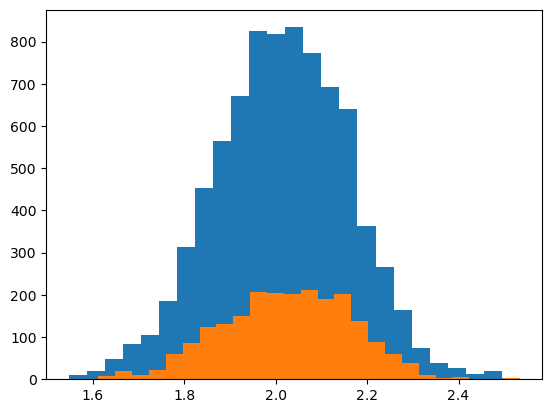

In [73]:
plt.hist(data.posterior.dY_dZ.values.ravel(), bins=25)
plt.hist(data.posterior.dY_dZ.where(mask).values.ravel(), bins=25);

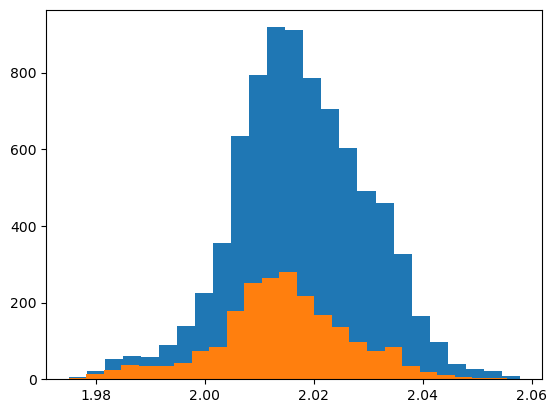

In [74]:
plt.hist(data.posterior.mu_a.values.ravel(), bins=25)
plt.hist(data.posterior.mu_a.where(mask).values.ravel(), bins=25);

In [82]:
import numpyro.distributions as dist
from jax import random

In [87]:
rng = random.PRNGKey(0)
rng, key = random.split(rng)
mh = dist.TruncatedNormal(0.0, 0.5, low=-0.9, high=0.5).sample(key, sample_shape=(10000,))

In [209]:
rng, key = random.split(rng)

mu_z = 0.01
sigma_z = 0.01

m_y = 1.5
c_y = 0.247
sigma_y = 0.005

mu_y = m_y * mu_z + c_y
mu = np.array([mu_z, mu_y])

# cov_zy = m_y * sigma_z**2
cov_yz = sigma_y**2 / m_y
cov = np.array(
    [
        [sigma_z**2, cov_yz],
        [cov_yz, sigma_y**2]
    ]
)
zy = dist.MultivariateNormal(mu, cov).sample(key, sample_shape=(10000,))

z, y = zy.T

x = 1 - y - z
mhp = np.log10(z/x) - np.log10(0.0181)
mask = ~np.isnan(mhp)

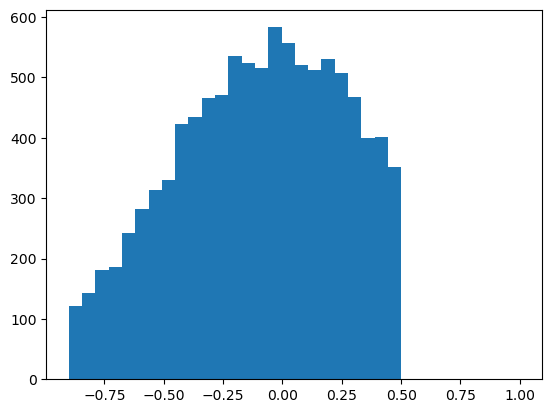

In [210]:
plt.hist(mh, bins=25);
plt.hist(mhp[mask], bins=25, alpha=0.5);

(0.24, 0.32)

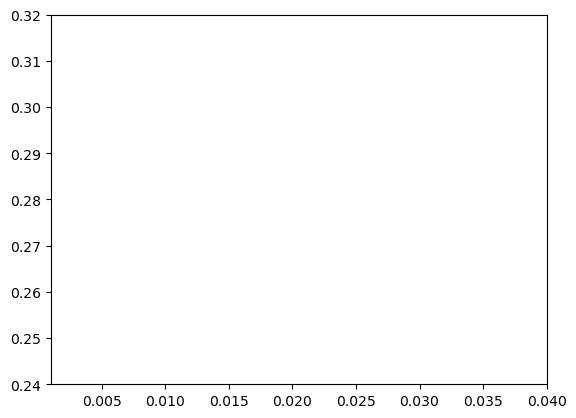

In [211]:
plt.scatter(z, y);
plt.xlim(0.001, 0.04);
plt.ylim(0.24, 0.32)

In [202]:
0.247 + 1.5 * 0.04

0.307

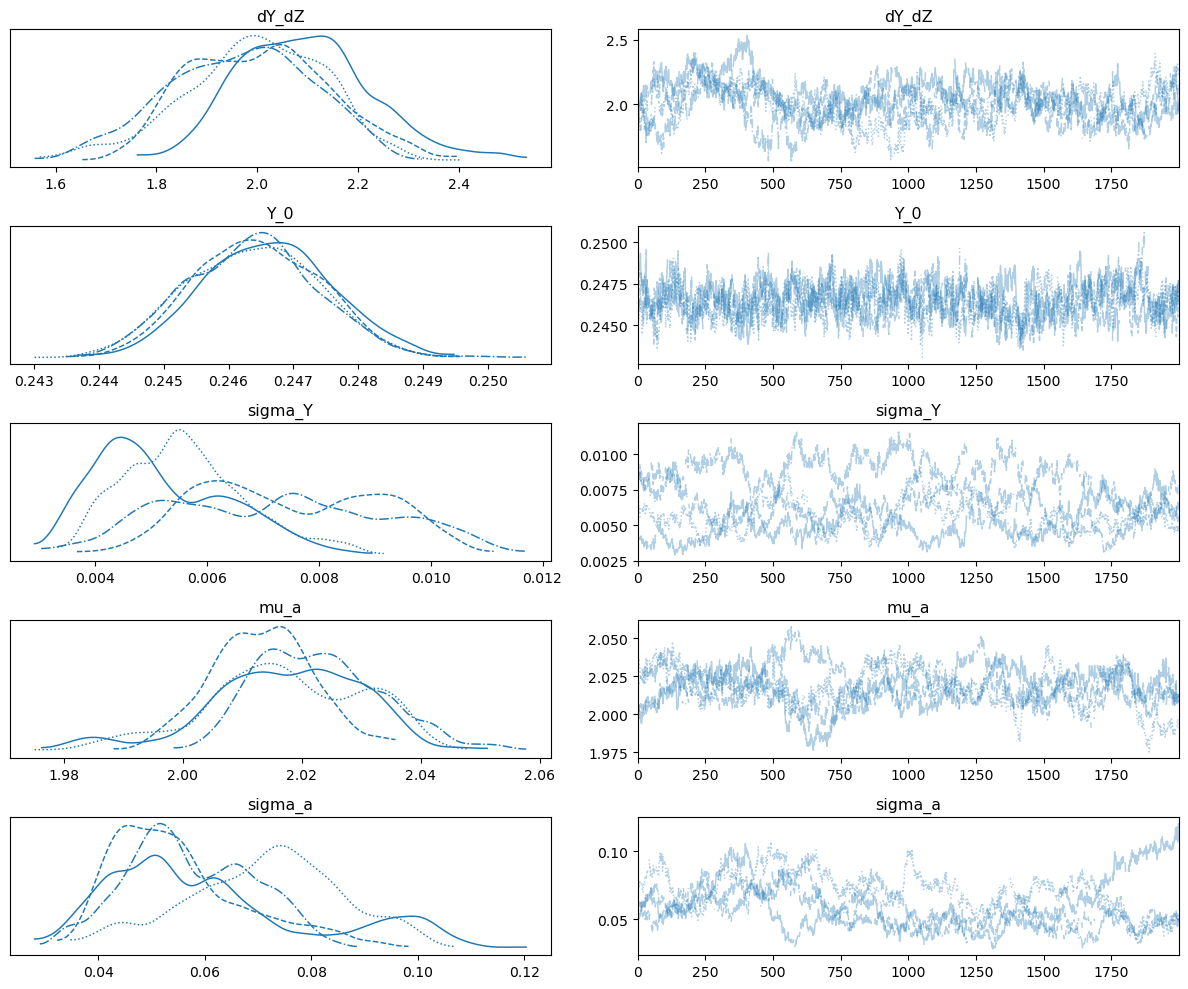

In [44]:
var_names = ["dY_dZ", "Y_0", "sigma_Y", "mu_a", "sigma_a"]
axes = az.plot_trace(data.posterior.where(mask), var_names=var_names)
plt.tight_layout()

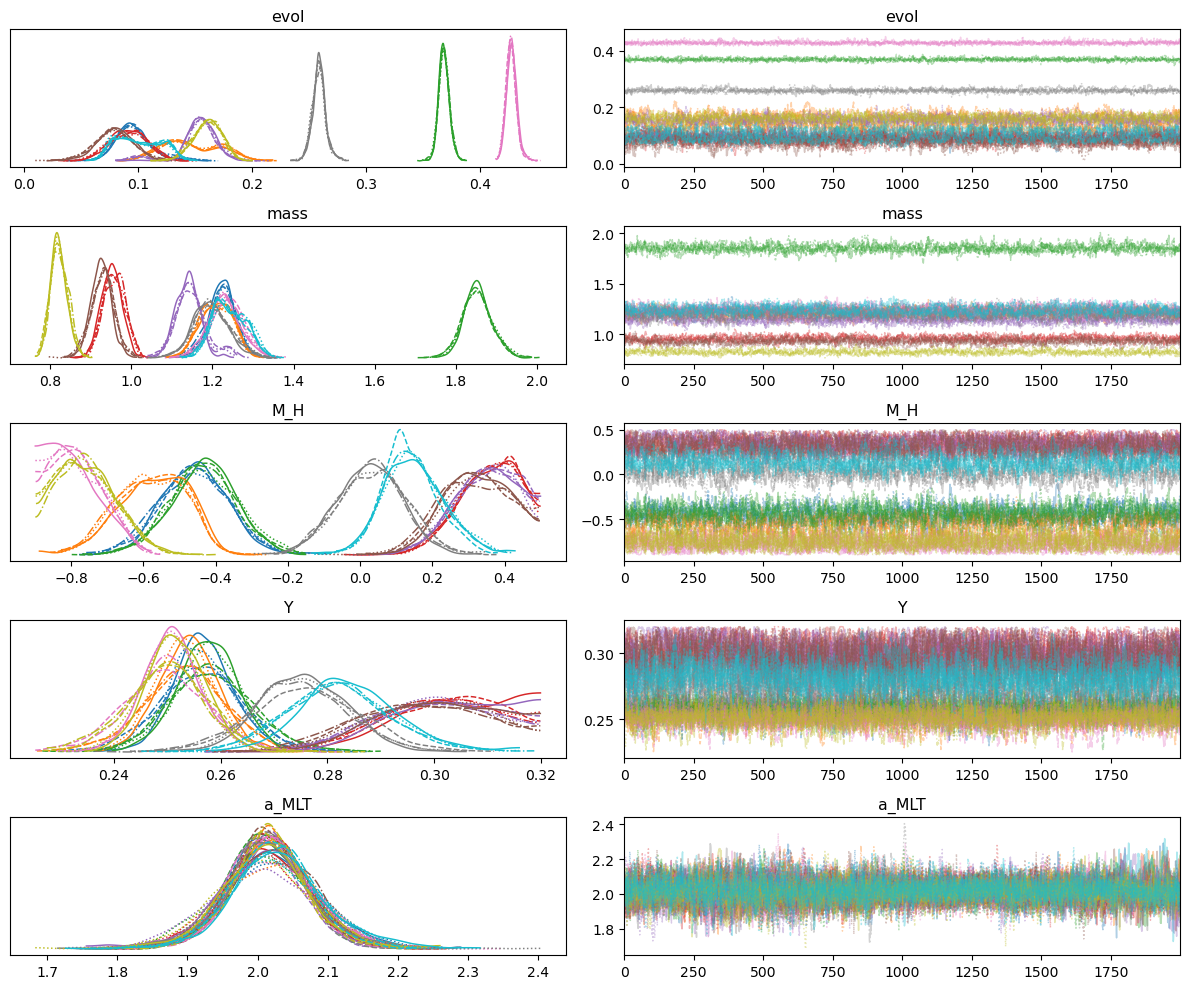

In [8]:
var_names = ["evol", "mass", "M_H", "Y", "a_MLT"]
axes = az.plot_trace(data, var_names=var_names, coords={"star": np.arange(10)})
plt.tight_layout()

In [76]:
directory = "/mnt/data-storage/alexlyttle/scalable-stellar-inference"
filename = "truths-nearest-neighbour-clean.csv"
truths = pd.read_csv(os.path.join(directory, filename), index_col=0)
truths.head()

,index,track,star,mass,Y,Zinit,a_MLT,fov_core,fov_shell,star_age,...,evol,bol_mag,abs_G,abs_BP,abs_RP,L,log_age,age,log_numax,numax
0,5135942,4716,64,1.21899,0.255556,0.004416,1.789752,0.000315,0.006041,2.053233e+09,...,0.097247,3.095263,3.064094,3.207612,2.798840,4.590869,0.312438,2.053233,3.253615,1793.142919
1,1047516,572,114,1.18823,0.256612,0.003238,2.030292,0.000000,0.006041,2.775791e+09,...,0.169591,2.839847,2.821199,2.948562,2.583362,5.808464,0.443387,2.775791,3.178939,1509.868130
2,2374686,2422,832,1.86401,0.255684,0.004760,2.040546,0.014332,0.006041,9.790699e+08,...,0.368276,0.849395,0.779131,1.029182,0.371158,36.328047,-0.009186,0.979070,2.295757,197.586545
3,4145653,6183,102,0.94165,0.278359,0.022493,1.983209,0.000000,0.006041,9.238255e+09,...,0.105998,5.050013,4.977653,5.352141,4.440660,0.758569,0.965590,9.238255,3.503079,3184.777124
4,3861544,1731,120,1.15933,0.285274,0.023931,1.880585,0.000000,0.006041,5.699361e+09,...,0.142149,3.812396,3.704555,4.010748,3.236899,2.371601,0.755826,5.699361,3.210789,1624.759176


In [33]:
truths_dict = truths.loc[data.posterior.star].to_dict(orient="list")

In [18]:
error = data.posterior - truths_dict

In [36]:
dims = ["chain", "draw"]
mean = data.posterior.mean(dims)
sd = data.posterior.std(dims)

In [37]:
z = (truths_dict - mean) / sd

In [42]:
z.mean()

<xarray.Dataset>
Dimensions:    ()
Data variables: (12/13)
    M_H        float64 -0.06747
    Y          float64 -0.6004
    a_MLT      float64 -0.3061
    evol       float64 -0.2281
    log_mass   float64 0.3492
    mass       float64 0.3513
    ...         ...
    log_Teff   float64 -0.2475
    log_R      float64 0.262
    log_Dnu    float64 0.02061
    log_L      float64 -0.003792
    log_g      float64 0.1815
    log_numax  float64 0.2264

In [43]:
z.std()

<xarray.Dataset>
Dimensions:    ()
Data variables: (12/13)
    M_H        float64 0.981
    Y          float64 1.051
    a_MLT      float64 1.082
    evol       float64 1.035
    log_mass   float64 0.99
    mass       float64 1.0
    ...         ...
    log_Teff   float64 0.8998
    log_R      float64 0.9097
    log_Dnu    float64 0.7583
    log_L      float64 0.7778
    log_g      float64 0.8322
    log_numax  float64 0.8518

In [49]:
from scipy.stats import norm
x = np.linspace(-3, 3, 101)
n01 = norm.pdf(x)

In [50]:
n01

array([0.00443185, 0.00529634, 0.00630673, 0.00748287, 0.00884645,
       0.01042093, 0.01223153, 0.01430511, 0.0166701 , 0.01935628,
       0.02239453, 0.02581658, 0.02965458, 0.03394076, 0.03870686,
       0.0439836 , 0.04980009, 0.05618314, 0.06315656, 0.07074039,
       0.07895016, 0.08779607, 0.09728227, 0.10740608, 0.1181573 ,
       0.1295176 , 0.14145997, 0.15394829, 0.16693704, 0.18037116,
       0.19418605, 0.20830779, 0.2226535 , 0.23713195, 0.25164434,
       0.26608525, 0.28034381, 0.29430503, 0.30785126, 0.3208638 ,
       0.3332246 , 0.344818  , 0.35553253, 0.36526267, 0.37391061,
       0.38138782, 0.38761662, 0.39253148, 0.39608021, 0.39822483,
       0.39894228, 0.39822483, 0.39608021, 0.39253148, 0.38761662,
       0.38138782, 0.37391061, 0.36526267, 0.35553253, 0.344818  ,
       0.3332246 , 0.3208638 , 0.30785126, 0.29430503, 0.28034381,
       0.26608525, 0.25164434, 0.23713195, 0.2226535 , 0.20830779,
       0.19418605, 0.18037116, 0.16693704, 0.15394829, 0.14145

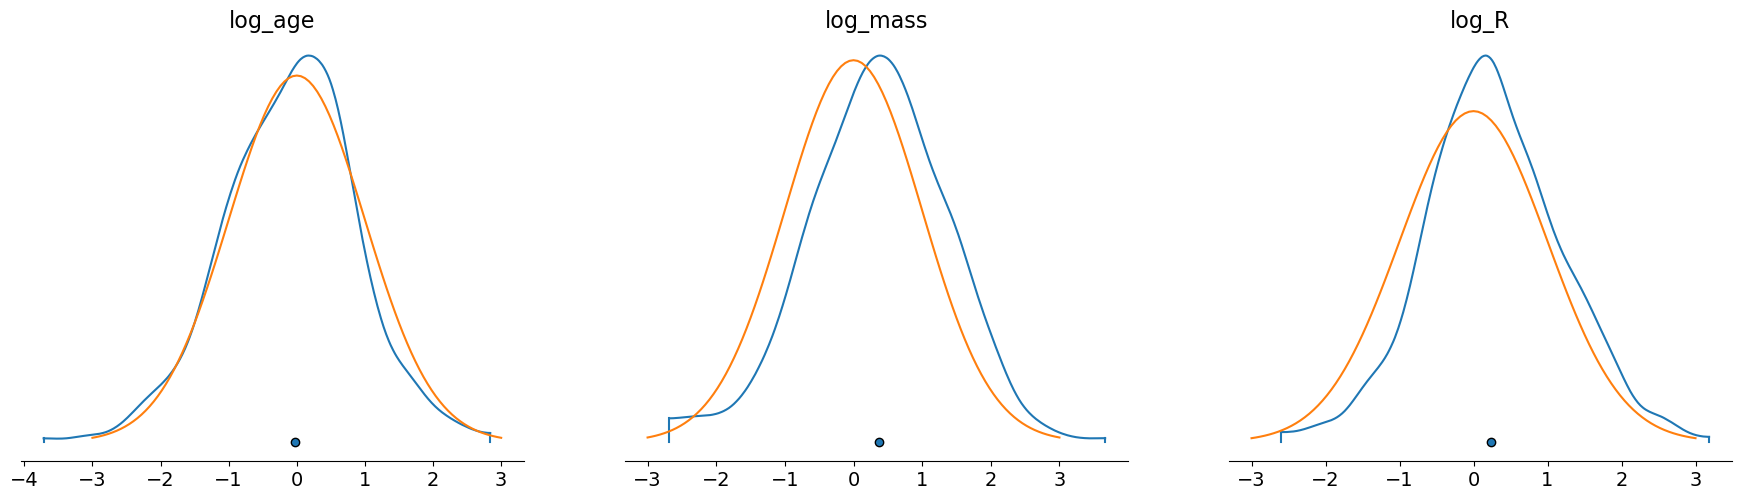

In [52]:
var_names = ["log_age", "log_mass", "log_R"]
axes = az.plot_density(z, var_names=var_names, combine_dims={"star"}, 
                       point_estimate="median", hdi_prob=1)
for ax in axes.ravel():
    ax.plot(x, n01, c="C1")

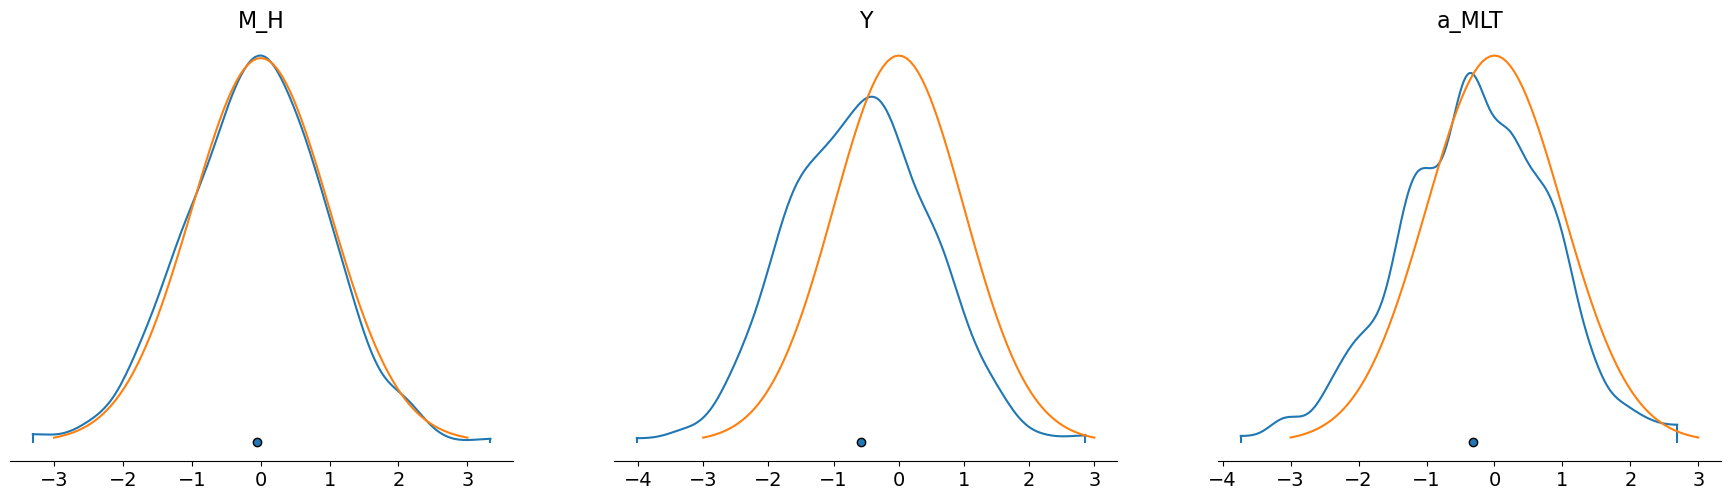

In [54]:
var_names = ["M_H", "Y", "a_MLT"]
axes = az.plot_density(z, var_names=var_names, combine_dims={"star"}, 
                point_estimate="median", hdi_prob=1)
for ax in axes.ravel():
    ax.plot(x, n01, c="C1")

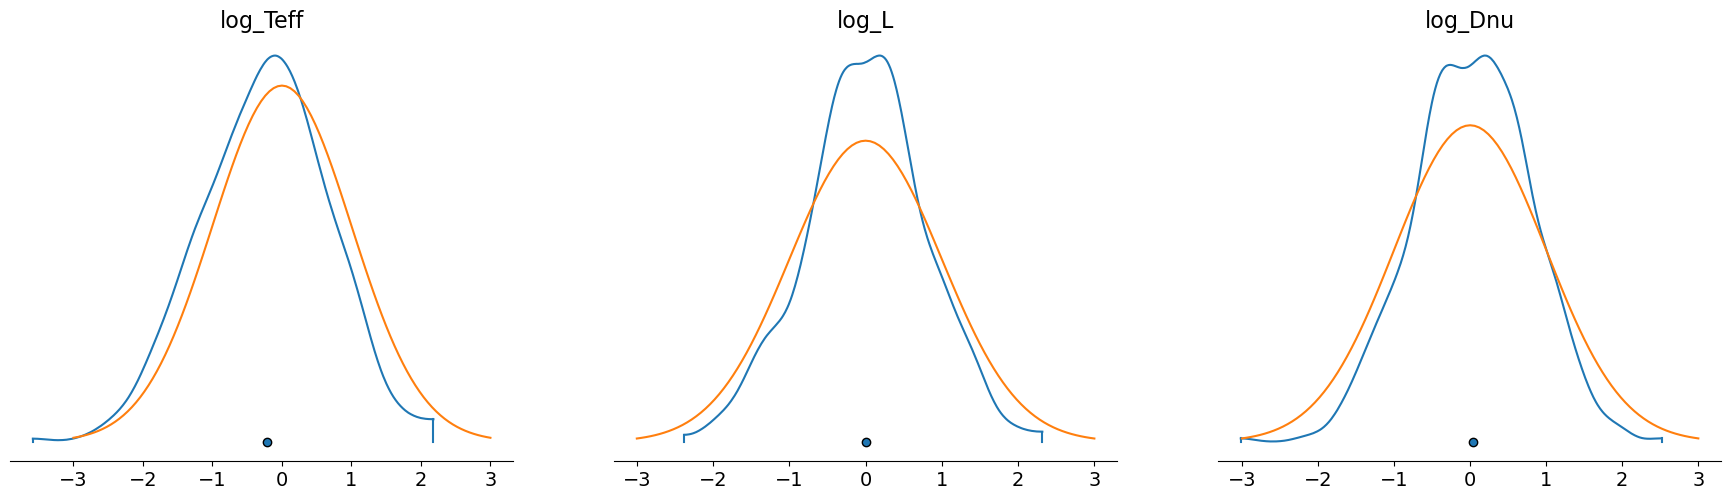

In [56]:
var_names = ["log_Teff", "log_L", "log_Dnu"]
axes = az.plot_density(z, var_names=var_names, combine_dims={"star"}, 
                point_estimate="median", hdi_prob=1)
for ax in axes.ravel():
    ax.plot(x, n01, c="C1")

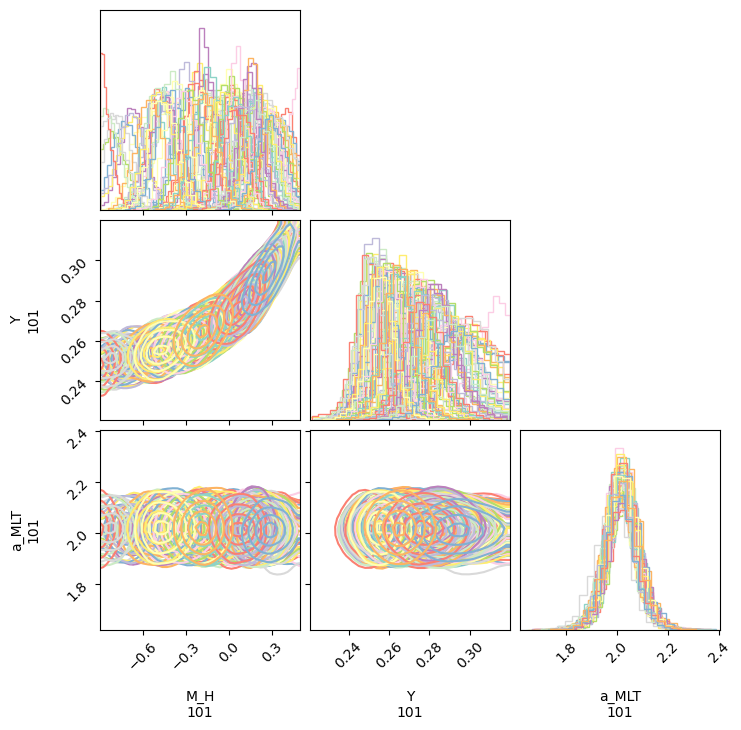

In [27]:
max_stars = 100
var_names = ["M_H", "Y", "a_MLT"]
cmap = colormaps["Set3"]
fig = None
for star in data.posterior.star[:max_stars]:
    coords_ = {"star": [star]}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(data, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)

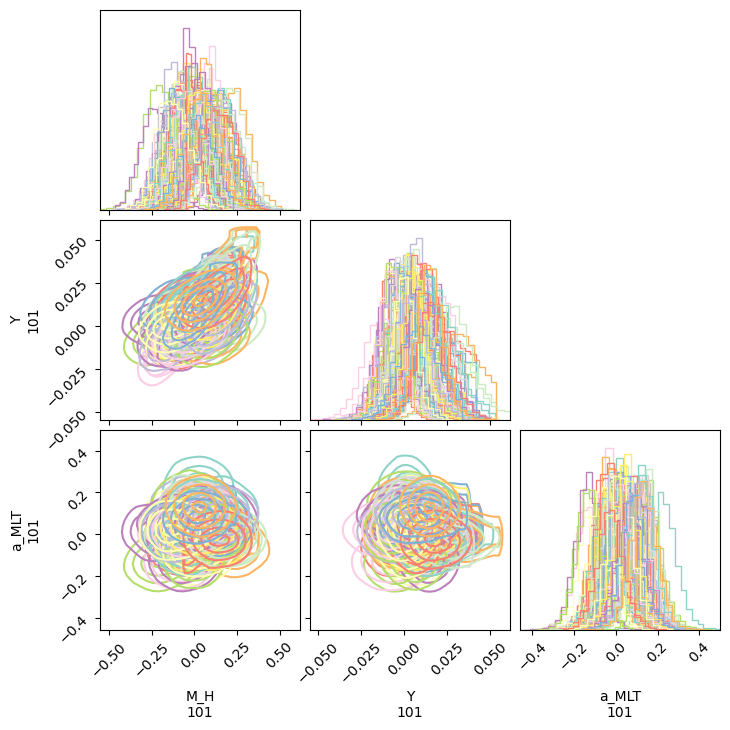

In [26]:
max_stars = 100
var_names = ["M_H", "Y", "a_MLT"]
cmap = colormaps["Set3"]
fig = None
for star in data.posterior.star[:max_stars]:
    coords_ = {"star": [star]}
    color = cmap(star%cmap.N)  # loop colors
    fig = corner(error, var_names=var_names, coords=coords_, color=color, fig=fig,
                 plot_datapoints=False, plot_density=False, smooth=1.0)

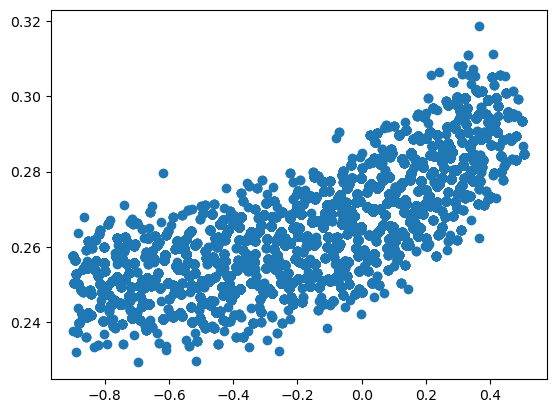

In [85]:
fig, ax = plt.subplots()

ax.scatter(truths["M_H"], truths["Y"])

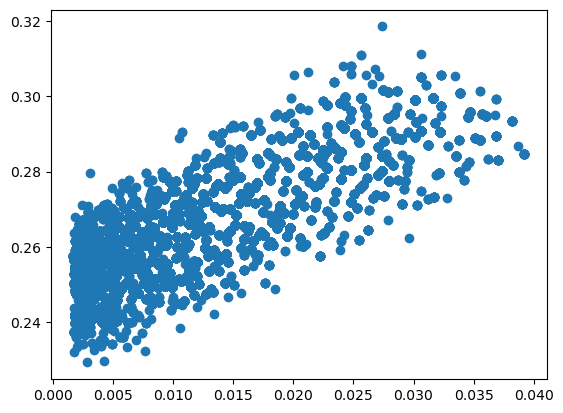

In [59]:
fig, ax = plt.subplots()

ax.scatter(truths["Zinit"], truths["Y"])

(array([ 760., 1067., 2095., 1606., 1827., 3943., 2568., 2812., 4372.,
        4576., 4782., 5059., 5859., 4331., 5656., 4355., 6172., 4849.,
        1212.,  401.]),
 array([-2.77053318, -2.70233994, -2.6341467 , -2.56595347, -2.49776023,
        -2.42956699, -2.36137375, -2.29318051, -2.22498727, -2.15679403,
        -2.08860079, -2.02040755, -1.95221431, -1.88402107, -1.81582784,
        -1.7476346 , -1.67944136, -1.61124812, -1.54305488, -1.47486164,
        -1.4066684 ]),
 <BarContainer object of 20 artists>)

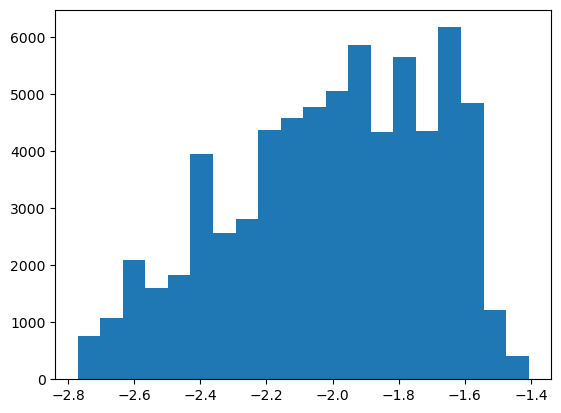

In [76]:
plt.hist(np.log10(truths["Zinit"]), bins=20)

In [80]:
loc=0.0
scale=0.5
low=-0.9
high=0.5

In [81]:
from scipy.stats import truncnorm

In [83]:
x = np.linspace(low, high, 101)
pdf = truncnorm.pdf(x, (low-loc)/scale, (high-loc)/scale, loc=0.0, scale=0.5)

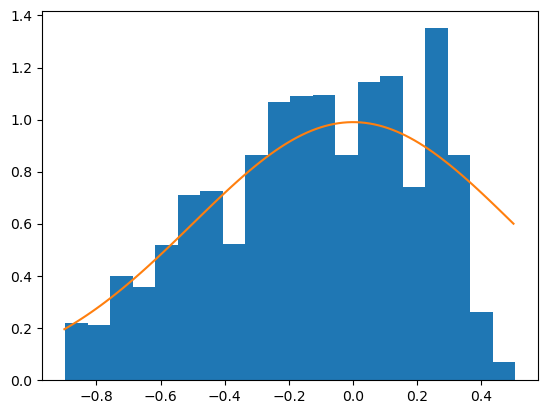

In [84]:
plt.hist((truths["M_H"]), bins=20, density=True)
plt.plot(x, pdf)

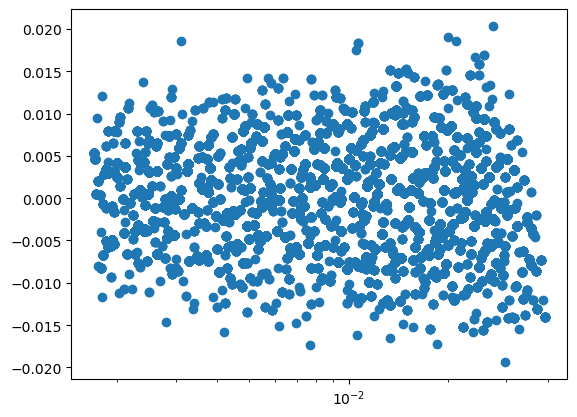

In [72]:
fig, ax = plt.subplots()

ax.scatter(truths["Zinit"], Z - truths["Zinit"])
ax.set_xscale("log")

In [88]:
from celestify.numpyro_models import SingleStarModel as Model

In [90]:
log_L = 2 * truths["log_R"] + 4 * (truths["log_Teff"] - Model.log_teff_sun)

In [93]:
(log_L - truths["log_L"]).min()

1.0320431639843086e-06

In [96]:
filename = "observables.csv"
obs = pd.read_csv(os.path.join(directory, filename), index_col=0)
obs = obs.loc[data.posterior.star]
obs = obs.iloc[]

In [97]:
obs

,M_H,log_Teff,log_L,log_Dnu,sigma_M_H,sigma_log_Teff,sigma_log_L,sigma_log_Dnu
0,-0.443383,3.857491,0.658871,1.936154,0.1,0.008686,0.008686,0.004343
1,-0.618704,3.860186,0.750427,1.891129,0.1,0.008686,0.008686,0.004343
2,-0.401424,3.802442,1.548845,1.174685,0.1,0.008686,0.008686,0.004343
3,0.365917,3.737094,-0.104814,2.144116,0.1,0.008686,0.008686,0.004343
4,0.343426,3.763235,0.375833,1.908047,0.1,0.008686,0.008686,0.004343
...,...,...,...,...,...,...,...,...
1046,0.247000,3.744737,0.774680,1.623044,0.1,0.008686,0.008686,0.004343
1047,-0.005991,3.682225,1.206847,1.110295,0.1,0.008686,0.008686,0.004343
1048,0.225733,3.778199,0.235222,2.023064,0.1,0.008686,0.008686,0.004343
1049,-0.215978,3.715383,1.191267,1.103671,0.1,0.008686,0.008686,0.004343


In [110]:
obs_z = (obs["log_Dnu"] - truths_dict["log_Dnu"]) / obs["sigma_log_Dnu"]

In [111]:
obs_z.mean()

-0.012856190746862178

In [112]:
obs_z.std()

1.0231677964979584

In [113]:
from scipy.stats import gamma